In [66]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple
from transformers import AutoTokenizer
import os

# add sdd to path
import sys
sys.path.append('./sdd')

from sdd.preprocessor import computeTfIdf, tfidfSample
from sdd.dataset import PretrainTableDataset
from sdd.model import BarlowTwinsSimCLR
from sdd.pretrain import load_checkpoint

from bertviz import head_view, model_view
# from bertviz.neuron_view import AttentionMultiView

class StarmieAttentionVisualizer:
    def __init__(self, checkpoint_path: str):
        """Initialize the visualizer with a Starmie checkpoint"""
        self.ckpt = torch.load(checkpoint_path)
        self.model, self.dataset = load_checkpoint(self.ckpt)
        # Set output_attentions=True when initializing
        self.model.bert.config.output_attentions = True
        self.model.eval()
        
        # Store the tokenizer from the dataset for reference
        self.tokenizer = self.dataset.tokenizer
        
    def process_table(self, table: pd.DataFrame, verbose: bool = False) -> Tuple[torch.Tensor, List[int], List[str]]:
        """Process a table and return its tokenized form with CLS token positions"""
        # Get tokenized sequence and column mapping using dataset's _tokenize method
        tokenized_seq, column_map = self.dataset._tokenize(table)
        
        if verbose:
            print("=== Tokenization Debug ===")
            print(f"Number of columns in table: {len(table.columns)}")
            print(f"Column names: {list(table.columns)}")
            print("\nColumn map (position of CLS tokens):")
            for col, pos in column_map.items():
                print(f"Column '{col}' -> CLS token at position {pos}")
            
            # Convert tokens to readable format and print segments
            token_strings = self.tokenizer.convert_ids_to_tokens(tokenized_seq)
            print(f"Tokenized sequence: {token_strings}")
            print("\nTokenized sequence by column:")
            current_cls = None
            current_segment = []
            for i, token in enumerate(token_strings):
                if token == self.tokenizer.cls_token:
                    if current_cls is not None:
                        print(f"Column segment: {' '.join(current_segment)}")
                    current_cls = i
                    current_segment = [token]
                else:
                    current_segment.append(token)
            if current_segment:
                print(f"Column segment: {' '.join(current_segment)}")
        
        # Convert to tensor and get CLS token positions
        tokens_tensor = torch.LongTensor([tokenized_seq]).to(self.model.device)
        cls_positions = [pos for col, pos in column_map.items()]
        token_strings = self.tokenizer.convert_ids_to_tokens(tokenized_seq)
        
        return tokens_tensor, cls_positions, token_strings
        
    def get_attention_weights(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Get attention weights from all layers and heads"""
        # Run forward pass with output_attentions=True
        with torch.no_grad():
            outputs = self.model.bert(input_ids, output_attentions=True)
            
        # Get attention weights from all layers
        # Shape: (n_layers, batch_size, n_heads, seq_len, seq_len)
        attention_weights = outputs.attentions
        
        return attention_weights
    
    def visualize_attention(self, table: pd.DataFrame, layer_idx: int = -1, head_idx: int = 0, verbose: bool = False):
        """Visualize attention patterns for a given table"""
        # Process table
        tokens_tensor, cls_positions, token_strings = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        
        # Get specific layer/head attention
        # Shape: (batch_size, seq_len, seq_len)
        layer_attention = attention_weights[layer_idx][0, head_idx].cpu().numpy()
        
        # Create attention heatmap
        plt.figure(figsize=(20, 10))
        sns.heatmap(layer_attention, 
                   xticklabels=token_strings,
                   yticklabels=token_strings,
                   cmap='YlOrRd')
        plt.xticks(rotation=90)
        plt.yticks(rotation=0)
        plt.title(f'Attention Weights (Layer {layer_idx}, Head {head_idx})')
        
        plt.show()
        plt.clf()
    
    def visualize_cls_attention(self, table: pd.DataFrame, layer_idx: int = -1, head_idx: int = 0, verbose: bool = False):
        """Visualize CLS-to-CLS attention patterns with actual column names"""
        # Process table
        tokens_tensor, cls_positions, token_strings = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        layer_attention = attention_weights[layer_idx][0, head_idx].cpu().numpy()
        
        # Only get CLS-to-CLS attention
        cls_attention = layer_attention[cls_positions][:, cls_positions]
        
        # Create readable labels - truncate if too long
        labels = []
        for col in table.columns:
            if len(col) > 10:
                label = col[:8] + "..."
            else:
                label = col
            labels.append(label)
        
        # Create figure with enough space for rotated labels
        plt.figure(figsize=(15, 12))
        
        # Create heatmap
        sns.heatmap(cls_attention,
                    xticklabels=labels,
                    yticklabels=labels,
                    cmap='YlOrRd',
                    center=0,
                    annot=True,
                    fmt='.5f',
                    square=True)
        
        # Rotate x-labels for better readability
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        
        plt.title(f'Column-to-Column Attention (Layer {layer_idx}, Head {head_idx})')
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        
        plt.show()
        plt.clf()

    def compare_cls_attention(self, table1: pd.DataFrame, table2: pd.DataFrame, 
                            layer_idx: int = -1, head_idx: int = 0, verbose: bool = False):
        """Compare CLS attention patterns between original and permuted table"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))
        
        # Process both tables
        tokens1, cls_pos1, _ = self.process_table(table1, verbose)
        tokens2, cls_pos2, _ = self.process_table(table2, verbose)
        
        # Get attention weights
        attn1 = self.get_attention_weights(tokens1)
        attn2 = self.get_attention_weights(tokens2)
        
        # Get CLS attention
        cls_attn1 = attn1[layer_idx][0, head_idx].cpu().numpy()[cls_pos1][:, cls_pos1]
        cls_attn2 = attn2[layer_idx][0, head_idx].cpu().numpy()[cls_pos2][:, cls_pos2]
        
        # Create readable labels
        def make_labels(columns):
            return [col[:10] + "..." if len(col) > 10 else col for col in columns]
        
        labels1 = make_labels(table1.columns)
        labels2 = make_labels(table2.columns)
        
        # Plot heatmaps
        sns.heatmap(cls_attn1, ax=ax1, 
                    xticklabels=labels1,
                    yticklabels=labels1,
                    cmap='YlOrRd',
                    center=0,
                    annot=True,
                    fmt='.5f',
                    square=True)
        
        sns.heatmap(cls_attn2, ax=ax2,
                    xticklabels=labels2,
                    yticklabels=labels2,
                    cmap='YlOrRd',
                    center=0,
                    annot=True,
                    fmt='.5f',
                    square=True)
        
        # Rotate labels for better readability
        for ax in [ax1, ax2]:
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
        ax1.set_title('Original Table\nColumn-to-Column Attention')
        ax2.set_title('Permuted Table\nColumn-to-Column Attention')
        
        plt.tight_layout()
        plt.show()
        plt.clf()

    def visualize_attention_across_heads(self, table: pd.DataFrame, layer_idx=-1, verbose: bool = False):
        """Visualize attention patterns across all heads in a given layer"""
        # Process table
        tokens_tensor, cls_positions, _ = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        
        # Get number of heads
        num_heads = attention_weights[0].shape[1]  # Usually 12 for RoBERTa-base
        
        # Create a grid of subplots
        fig = plt.figure(figsize=(25, 20))
        n_rows = (num_heads + 3) // 4  # 4 plots per row
        
        # Create readable labels
        labels = [col[:8] + "..." if len(col) > 10 else col for col in table.columns]
        
        # Plot each head's attention pattern
        for head in range(num_heads):
            ax = plt.subplot(n_rows, 4, head + 1)
            
            # Get attention for this head
            layer_attention = attention_weights[layer_idx][0, head].cpu().numpy()
            cls_attention = layer_attention[cls_positions][:, cls_positions]
            
            # Create heatmap
            sns.heatmap(cls_attention,
                        xticklabels=labels,
                        yticklabels=labels,
                        cmap='YlOrRd',
                        center=0,
                        annot=False,  # Remove annotations as they'd be too crowded
                        square=True,
                        ax=ax)
            
            # Rotate labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            
            ax.set_title(f'Head {head}')
        
        plt.suptitle(f'Column Attention Patterns Across All Heads (Layer {layer_idx})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        plt.clf()

    def visualize_attention_across_layers(self, table: pd.DataFrame, head_idx=0, verbose: bool = False):
        """Visualize attention patterns across all layers for a specific head"""
        # Process table
        tokens_tensor, cls_positions, _ = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        num_layers = len(attention_weights)
        
        # Create a grid of subplots
        fig = plt.figure(figsize=(25, 20))
        n_rows = (num_layers + 3) // 4  # 4 plots per row
        
        # Create readable labels
        labels = [col[:8] + "..." if len(col) > 10 else col for col in table.columns]
        
        # Plot each layer's attention pattern
        for layer in range(num_layers):
            ax = plt.subplot(n_rows, 4, layer + 1)
            
            # Get attention for this layer
            layer_attention = attention_weights[layer][0, head_idx].cpu().numpy()
            cls_attention = layer_attention[cls_positions][:, cls_positions]
            
            # Create heatmap
            sns.heatmap(cls_attention,
                        xticklabels=labels,
                        yticklabels=labels,
                        cmap='YlOrRd',
                        center=0,
                        annot=False,  # Remove annotations as they'd be too crowded
                        square=True,
                        ax=ax)
            
            # Rotate labels
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
            ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
            
            ax.set_title(f'Layer {layer}')
        
        plt.suptitle(f'Column Attention Patterns Across All Layers (Head {head_idx})', fontsize=16, y=1.02)
        plt.tight_layout()
        plt.show()
        plt.clf()

    # def compare_attention_patterns(self, table1: pd.DataFrame, table2: pd.DataFrame, 
    #                             layer_idx=-1, verbose=False):
    #     """Compare attention patterns between original and permuted tables across all heads"""
    #     if verbose:
    #         print("Processing tables...")
    #         print("Original table columns:", table1.columns.tolist())
    #         print("Permuted table columns:", table2.columns.tolist())
        
    #     # Store original column order
    #     original_columns = table1.columns.tolist()
        
    #     # Process tables
    #     tokens1, cls_pos1, _ = self.process_table(table1, verbose)
    #     tokens2, cls_pos2, _ = self.process_table(table2, verbose)
        
    #     # Get attention weights
    #     attn1 = self.get_attention_weights(tokens1)
    #     attn2 = self.get_attention_weights(tokens2)
        
    #     # Get number of heads
    #     num_heads = attn1[0].shape[1]
    #     if verbose:
    #         print(f"Number of attention heads: {num_heads}")
        
    #     # Create readable labels
    #     labels = [col[:10] + "..." if len(col) > 10 else col for col in original_columns]
        
    #     # Calculate grid dimensions
    #     n_cols = 4
    #     n_rows = (num_heads + n_cols - 1) // n_cols * 2
        
    #     # Create figure with subplots for each head
    #     fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 4*n_rows))
        
    #     # Get permutation indices to reorder attention matrix
    #     permutation_indices = [table2.columns.get_loc(col) for col in original_columns]
    #     if verbose:
    #         print("Permutation indices for realignment:", permutation_indices)
        
    #     for head in range(num_heads):
    #         if verbose:
    #             print(f"Processing head {head}...")
            
    #         row_orig = (head // n_cols) * 2
    #         row_perm = row_orig + 1
    #         col = head % n_cols
            
    #         # Original table attention
    #         layer_attention = attn1[layer_idx][0, head].cpu().numpy()
    #         cls_attention_orig = layer_attention[cls_pos1][:, cls_pos1]
            
    #         # Permuted table attention - reorder to match original
    #         layer_attention = attn2[layer_idx][0, head].cpu().numpy()
    #         cls_attention_perm = layer_attention[cls_pos2][:, cls_pos2]
    #         # Reorder both rows and columns to match original order
    #         cls_attention_perm = cls_attention_perm[permutation_indices][:, permutation_indices]
            
    #         if verbose and head == 0:
    #             print("\nFirst head attention shapes:")
    #             print("Original attention shape:", cls_attention_orig.shape)
    #             print("Permuted attention shape:", cls_attention_perm.shape)
            
    #         # Plot original
    #         sns.heatmap(cls_attention_orig,
    #                     xticklabels=labels,
    #                     yticklabels=labels,
    #                     cmap='RdYlBu_r',
    #                     center=0,
    #                     annot=False,
    #                     square=True,
    #                     ax=axes[row_orig, col])
            
    #         axes[row_orig, col].set_title(f'Original - Head {head}')
            
    #         # Plot permuted (reordered)
    #         sns.heatmap(cls_attention_perm,
    #                     xticklabels=labels,
    #                     yticklabels=labels,
    #                     cmap='RdYlBu_r',
    #                     center=0,
    #                     annot=False,
    #                     square=True,
    #                     ax=axes[row_perm, col])
            
    #         axes[row_perm, col].set_title(f'Permuted - Head {head}')
            
    #         # Rotate labels
    #         for ax in [axes[row_orig, col], axes[row_perm, col]]:
    #             ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    #             ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        
    #     # Remove empty subplots if any
    #     for i in range(num_heads, n_cols):
    #         if i < n_cols:
    #             axes[-2, i].remove()
    #             axes[-1, i].remove()
        
    #     plt.suptitle(f'Attention Patterns Comparison Across All Heads (Layer {layer_idx})', 
    #                 fontsize=16, y=1.02)
    #     plt.tight_layout()
    #     plt.show()
    #     plt.clf()

    def compare_attention_patterns(self, table1: pd.DataFrame, table2: pd.DataFrame, 
                                layer_idx=-1, verbose=False):
        """Compare attention patterns between original and permuted tables across all heads by showing their differences"""
        # Process tables
        tokens1, cls_pos1, _ = self.process_table(table1, verbose)
        tokens2, cls_pos2, _ = self.process_table(table2, verbose)
        
        # Get attention weights
        attn1 = self.get_attention_weights(tokens1)
        attn2 = self.get_attention_weights(tokens2)
        
        # Get number of heads
        num_heads = attn1[0].shape[1]
        
        # Get permutation indices to reorder attention matrix
        permutation_indices = [table2.columns.get_loc(col) for col in table1.columns]
        
        # Calculate differences and find max absolute difference for consistent scaling
        differences = []
        max_diff = 0
        
        for head in range(num_heads):
            # Original table attention
            layer_attention = attn1[layer_idx][0, head].cpu().numpy()
            cls_attention_orig = layer_attention[cls_pos1][:, cls_pos1]
            
            # Permuted table attention - reorder to match original
            layer_attention = attn2[layer_idx][0, head].cpu().numpy()
            cls_attention_perm = layer_attention[cls_pos2][:, cls_pos2]
            cls_attention_perm = cls_attention_perm[permutation_indices][:, permutation_indices]
            
            # Calculate difference
            difference = cls_attention_orig - cls_attention_perm
            differences.append(difference)
            max_diff = max(max_diff, np.abs(difference).max())
        
        # Plot 12 heads per figure (2 rows x 6 columns)
        heads_per_figure = 12
        num_figures = (num_heads + heads_per_figure - 1) // heads_per_figure
        
        for fig_idx in range(num_figures):
            fig, axes = plt.subplots(2, 6, figsize=(40, 15))
            axes = axes.flatten()
            
            for subplot_idx in range(heads_per_figure):
                head_idx = fig_idx * heads_per_figure + subplot_idx
                if head_idx >= num_heads:
                    axes[subplot_idx].remove()
                    continue
                    
                difference = differences[head_idx]
                
                # Plot difference
                sns.heatmap(difference,
                            xticklabels=table1.columns,
                            yticklabels=table1.columns,
                            cmap='RdBu_r',
                            center=0,
                            vmin=-max_diff,
                            vmax=max_diff,
                            annot=True,
                            fmt='.2f',
                            square=True,
                            cbar=False,
                            ax=axes[subplot_idx])
                
                axes[subplot_idx].set_title(f'Head {head_idx}', pad=20)
                
                # Adjust x-axis labels position and rotation
                axes[subplot_idx].set_xticklabels(
                    axes[subplot_idx].get_xticklabels(),
                    rotation=45,
                    ha='right',
                    fontsize=12,
                )
                
                # Set y-axis labels
                axes[subplot_idx].set_yticklabels(
                    axes[subplot_idx].get_yticklabels(),
                    rotation=0,
                    fontsize=12
                )
            
            plt.suptitle(
                f'Attention Pattern Differences (Layer {layer_idx}) - Heads {fig_idx*12} to {min((fig_idx+1)*12-1, num_heads-1)}\n' +
                'Red: Original > Permuted, Blue: Permuted > Original',
                fontsize=16,
                y=1.02
            )
            
            # Add more space at the bottom and between subplots
            plt.subplots_adjust(bottom=0.2, hspace=0.4, wspace=0.4)
            plt.show()
            plt.clf()

    def visualize_attention_bertviz(self, table: pd.DataFrame, verbose: bool = False):
        """Visualize attention patterns using BertViz's head view"""
        # Process table
        tokens_tensor, cls_positions, token_strings = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        
        # Convert to format expected by BertViz
        # We'll create a list of tensors, one per layer
        formatted_attention = []
        for layer_attention in attention_weights:
            # Add batch dimension if needed
            if len(layer_attention.shape) == 3:
                layer_attention = layer_attention.unsqueeze(0)
            formatted_attention.append(layer_attention.cpu())
        
        if verbose:
            print("Number of layers:", len(formatted_attention))
            print("Shape of first layer:", formatted_attention[0].shape)
        
        # Create the visualization
        head_view(formatted_attention, token_strings, include_layers=[10,11])
    
    
    def visualize_full_model_attention(self, table: pd.DataFrame, verbose: bool = False):
        """Visualize attention patterns across all layers and heads using BertViz model view"""
        # Process table
        tokens_tensor, _, token_strings = self.process_table(table, verbose)
        
        # Get attention weights for all layers
        attention_weights = self.get_attention_weights(tokens_tensor)
        
        # Convert to format expected by BertViz model view
        attention = tuple(attn.cpu() for attn in attention_weights)
        
        if verbose:
            print("Number of layers:", len(attention))
            print("Attention shape for first layer:", attention[0].shape)
        
        # Create the visualization
        model_view(attention, token_strings,include_layers=[10,11],display_mode='light')
    
    def visualize_column_attention(self, table: pd.DataFrame, layer_idx: int = -1, head_idx: int = 0, verbose: bool = False):
        """Visualize attention patterns between columns by aggregating token-level attention"""
        # Process table
        tokens_tensor, cls_positions, token_strings = self.process_table(table, verbose)
        
        # Get attention weights
        attention_weights = self.get_attention_weights(tokens_tensor)
        
        # Get attention for specific layer and head
        layer_attention = attention_weights[layer_idx][0, head_idx].cpu().numpy()
        
        # Create column segments mapping
        column_segments = []
        for i in range(len(cls_positions)):
            start = cls_positions[i]
            end = cls_positions[i + 1] if i < len(cls_positions) - 1 else len(token_strings)
            segment = {
                'name': table.columns[i],
                'start': start,
                'end': end,
                'tokens': token_strings[start:end]
            }
            column_segments.append(segment)
        
        # Calculate aggregated attention between columns
        num_columns = len(column_segments)
        column_attention = np.zeros((num_columns, num_columns))
        
        for i, src_col in enumerate(column_segments):
            for j, tgt_col in enumerate(column_segments):
                # Get the attention submatrix for this column pair
                src_slice = slice(src_col['start'], src_col['end'])
                tgt_slice = slice(tgt_col['start'], tgt_col['end'])
                attention_submatrix = layer_attention[src_slice, tgt_slice]
                
                # Aggregate attention (you can try different aggregation methods)
                # Option 1: Average attention
                # column_attention[i, j] = np.mean(attention_submatrix)
                # Option 2: Max attention
                # column_attention[i, j] = np.max(attention_submatrix)
                # Option 3: CLS token attention only
                column_attention[i, j] = layer_attention[src_col['start'], tgt_col['start']]
        
        # Create visualization using networkx and matplotlib
        import networkx as nx
        import matplotlib.pyplot as plt
        
        # Create graph
        G = nx.DiGraph()
        
        # Add nodes
        for i, col in enumerate(table.columns):
            G.add_node(col)
        
        # Add edges with weights based on attention
        for i, src_col in enumerate(table.columns):
            for j, tgt_col in enumerate(table.columns):
                if i != j:  # Skip self-loops if you want
                    weight = column_attention[i, j]
                    if weight > 0.1:  # You can adjust this threshold
                        G.add_edge(src_col, tgt_col, weight=weight)
        
        # Create layout
        pos = nx.spring_layout(G)
        
        # Draw the graph
        plt.figure(figsize=(12, 8))
        
        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue', 
                            node_size=2000, alpha=0.7)
        
        # Draw edges with width proportional to attention weight
        edges = G.edges(data=True)
        weights = [d['weight'] * 10 for (u, v, d) in edges]  # Scale weights for visibility
        nx.draw_networkx_edges(G, pos, edge_color='gray',
                            width=weights, alpha=0.6,
                            arrowsize=20)
        
        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=10)
        
        plt.title(f'Column-to-Column Attention Patterns (Layer {layer_idx}, Head {head_idx})')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

In [67]:
visualizer = StarmieAttentionVisualizer('/home/boutalebm/github-repos/starmie/results/tus/model_drop_cell_alphaHead_column_0.pt')


cuda


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [68]:
# Load tables
benchmark = 'tus'
table_name = 't_67c3f7ce5eab8804____c9_1____2.csv'

original_table = pd.read_csv(f'/home/boutalebm/github-repos/starmie/data/{benchmark}/datalake/{table_name}')
permuted_table = pd.read_csv(f'/home/boutalebm/github-repos/starmie/data/{benchmark}-p-col/datalake/{table_name}')

_, _, _ = visualizer.process_table(original_table, verbose=True)
_, _, _ = visualizer.process_table(permuted_table, verbose=True)

=== Tokenization Debug ===
Number of columns in table: 9
Column names: ['Bearing', 'CreationDateTime', 'Indicator', 'Landmark', 'LocalityName', 'ModificationDateTime', 'Notes', 'StopType', 'Street']

Column map (position of CLS tokens):
Column 'Bearing' -> CLS token at position 0
Column 'CreationDateTime' -> CLS token at position 12
Column 'Indicator' -> CLS token at position 25
Column 'Landmark' -> CLS token at position 38
Column 'LocalityName' -> CLS token at position 51
Column 'ModificationDateTime' -> CLS token at position 64
Column 'Notes' -> CLS token at position 77
Column 'StopType' -> CLS token at position 90
Column 'Street' -> CLS token at position 98
Tokenized sequence: ['<s>', 'Ġe', 'Ġn', 'Ġne', 'Ġn', 'w', 'Ġs', 'Ġse', 'Ġsw', 'Ġw', 'Ġnan', 'Ġ', '<s>', 'Ġ2004', '-', '09', '-', '14', 't', '00', ':', '00', ':', '00', 'Ġ2005', '<s>', 'Ġbo', 'arsh', 'aw', 'Ġlane', 'Ġbury', 'Ġold', 'Ġroad', 'Ġ-', 'Ġwh', 'itt', 'aker', 'Ġcor', '<s>', 'Ġbo', 'arsh', 'aw', 'Ġlane', 'Ġbroad', 'way', '

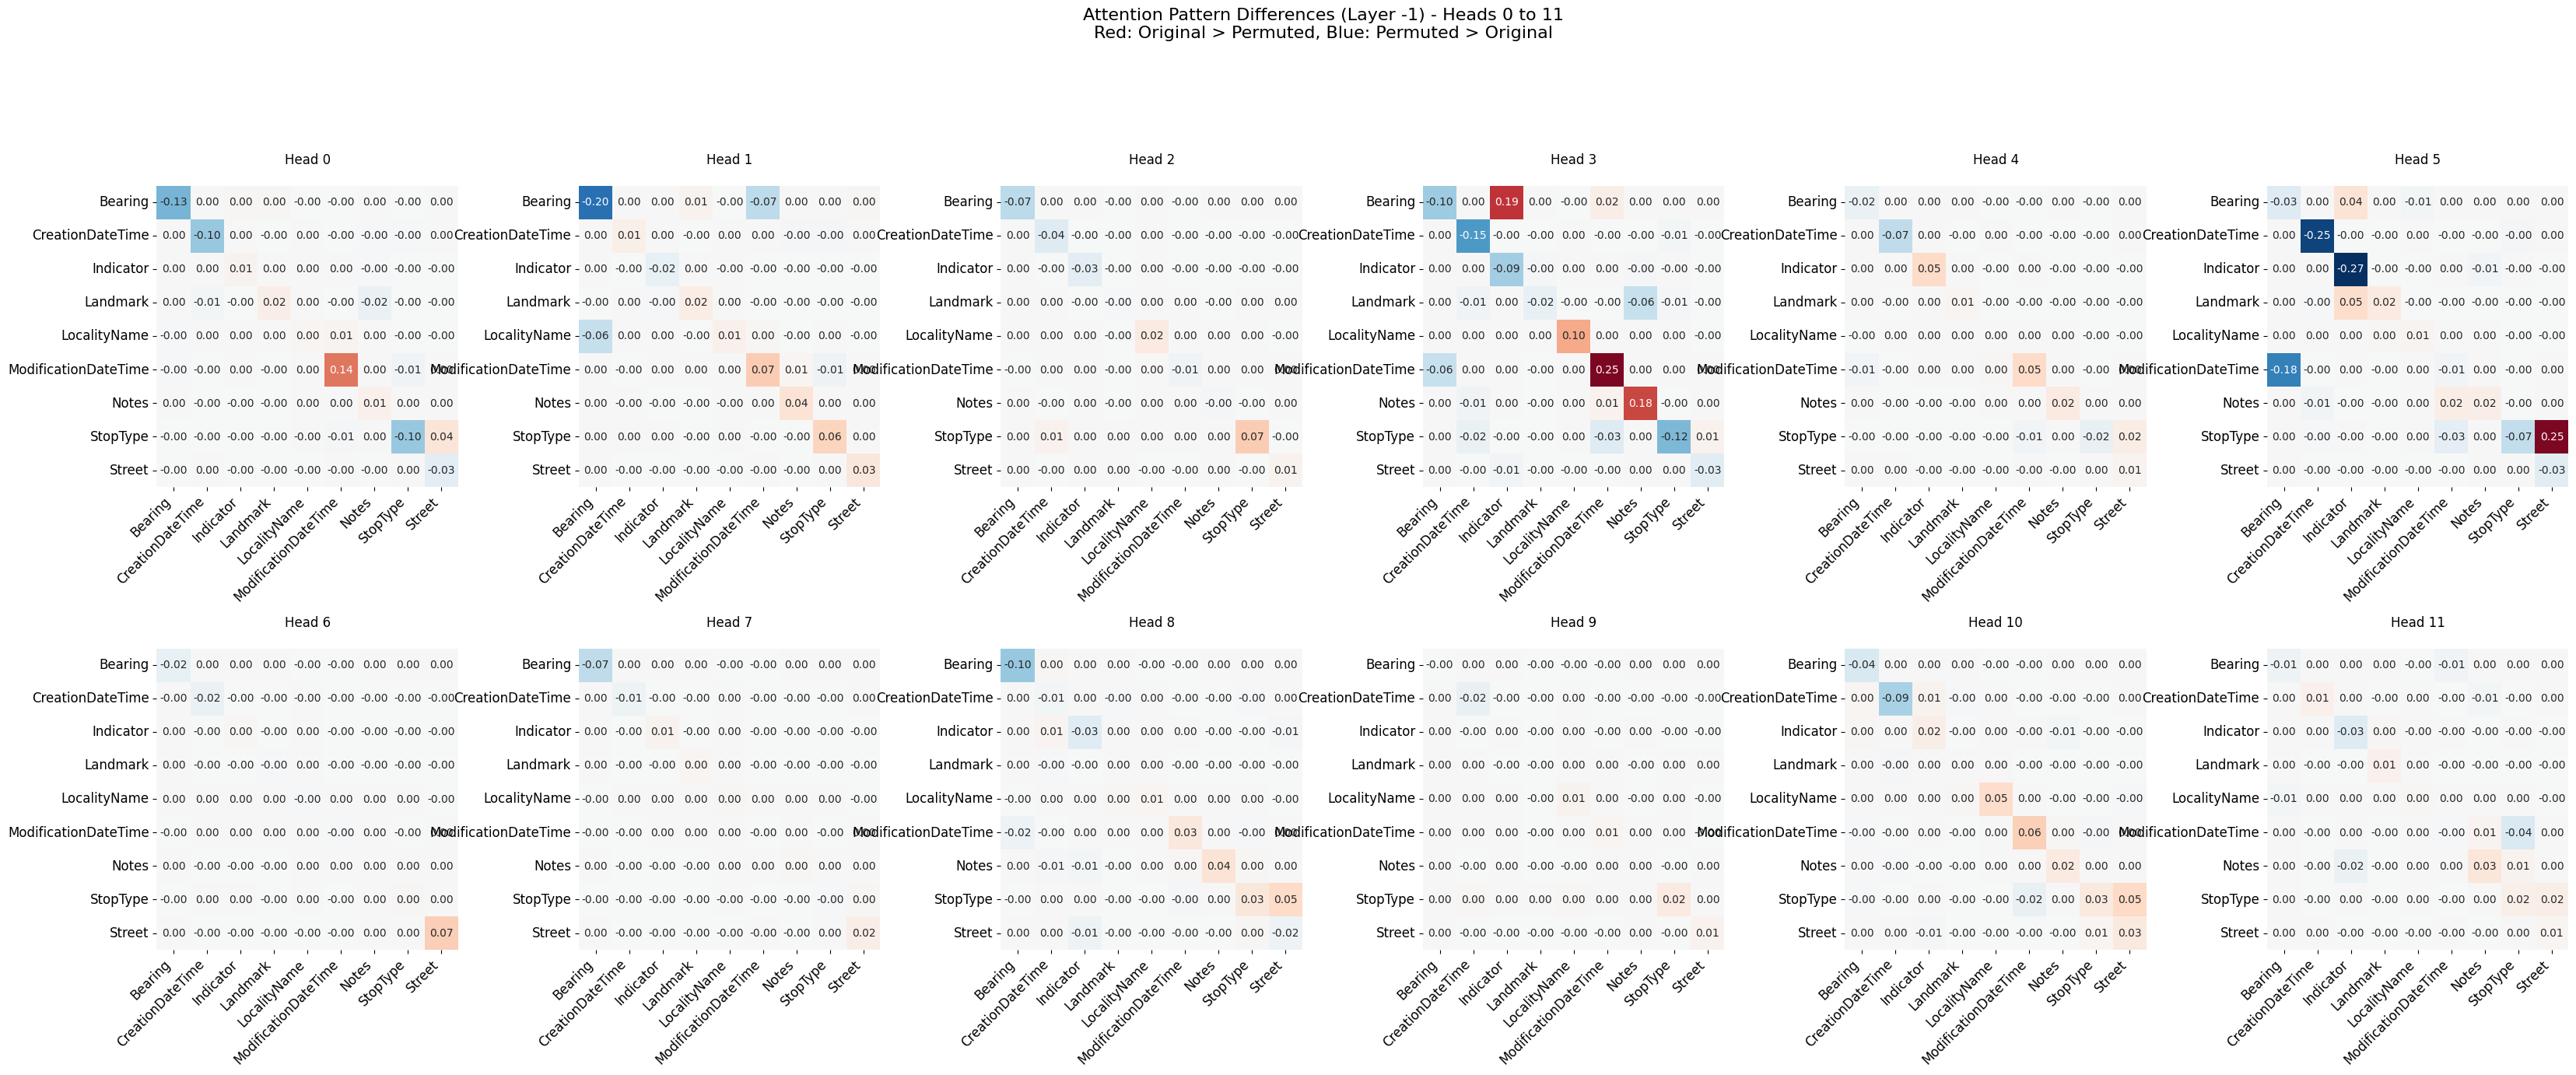

<Figure size 640x480 with 0 Axes>

In [69]:
visualizer.compare_attention_patterns(original_table, permuted_table)

In [3]:
# visualizer.visualize_attention_bertviz(permuted_table, verbose=False)


In [4]:
# visualizer.compare_cls_attention(original_table, permuted_table)

In [5]:
# visualizer.visualize_attention_across_heads(original_table)

In [6]:
# visualizer.visualize_attention_across_heads(permuted_table)

In [7]:
# visualizer.visualize_attention_across_layers(original_table)